### 데이터 구성

* 시계열 센서 데이터 (Water Circulation System)
* 데이터 명세  

|Column|Description|
|:---|:---|
|datetime|시간|
|Accelerometer1RMS|진동 가속도1|
|Accelerometer2RMS|진동 가속도2|
|Current |전기모터 암페어(Ampere)|
|Pressure|워터 펌프 후 루프의 압력(Bar) |
|Temperature|엔진의 온도(섭씨 온도)|
|Thermocouple|순환 루프에서 유체의 온도(섭씨 온도)|
|Voltage|전기 모터의 전압(Volt)|
|Volume Flow RateRMS|루프 내부의 유체의 순환 유량(Liter/min)|
|anomaly|이상여부|
|changepoint|변경점 여부|

    - 와우 "이상여부"가 있다. label 존재 !!

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

# 경고메시지 무시할 때
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 읽어오기, 구분자가 ,가 아니고 ; 이네요.
df = pd.read_csv("물순환설비데이터.csv", sep=";")

In [2]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
data = df.drop('2020-03-09 16:35:27', axis=0)
data_re = data.resample('1s').mean()

In [3]:
X = data_re.drop('anomaly', axis=1).interpolate(method='linear')
y = data_re['anomaly']
y = y.bfill()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(data_re['anomaly']==1).sum() / len(data_re), shuffle=True, stratify=y, random_state=42)

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

n_features = X_train.shape[1]
latent_dim = 3  # 더 높은 latent_dim을 사용하여 더 많은 정보 압축

# 인코더
enc_inputs = layers.Input(shape=(n_features,))
x = layers.Dense(64, activation='relu')(enc_inputs)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)  # 더 깊은 층 추가
x = layers.Dense(8, activation='relu')(x)  # 더 깊은 층 추가
enc_outputs = layers.Dense(latent_dim, activation='relu')(x)

encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# 디코더
dec_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8, activation='relu')(dec_inputs)  # 더 깊은 층 추가
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
dec_outputs = layers.Dense(n_features, activation='linear')(x)

decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# 오토인코더
inputs = layers.Input(shape=(n_features,))
latent = encoder(inputs)
outputs = decoder(latent)

AE = Model(inputs=inputs, outputs=outputs)
AE.compile(optimizer='adam', loss='mse')
AE.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 model (Functional)          (None, 3)                 3411      
                                                                 
 model_1 (Functional)        (None, 9)                 3417      
                                                                 
Total params: 6828 (26.67 KB)
Trainable params: 6828 (26.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

AE.fit(X_train, X_train, validation_split=0.2, batch_size=128, epochs=2000, callbacks=[early_stopping]) # 압축 후 복원하기 때문에, 자신과 비교

Epoch 1/2000
6/6 [==============================] - 1s 35ms/step - loss: 6531.2773 - val_loss: 6405.8433
Epoch 2/2000
6/6 [==============================] - 0s 6ms/step - loss: 6325.8833 - val_loss: 6114.9678
Epoch 3/2000
6/6 [==============================] - 0s 5ms/step - loss: 5965.9487 - val_loss: 5598.3594
Epoch 4/2000
6/6 [==============================] - 0s 5ms/step - loss: 5313.8330 - val_loss: 4687.2983
Epoch 5/2000
6/6 [==============================] - 0s 6ms/step - loss: 4196.9883 - val_loss: 3212.7151
Epoch 6/2000
6/6 [==============================] - 0s 7ms/step - loss: 2541.0176 - val_loss: 1387.6071
Epoch 7/2000
6/6 [==============================] - 0s 6ms/step - loss: 904.7970 - val_loss: 487.1038
Epoch 8/2000
6/6 [==============================] - 0s 6ms/step - loss: 503.7145 - val_loss: 336.2734
Epoch 9/2000
6/6 [==============================] - 0s 5ms/step - loss: 160.2220 - val_loss: 14.3671
Epoch 10/2000
6/6 [==============================] - 0s 5ms/step - los

In [7]:
p_test = AE.predict(X_test)
p_test.shape

11/11 [==============================] - 0s 700us/step


(333, 9)

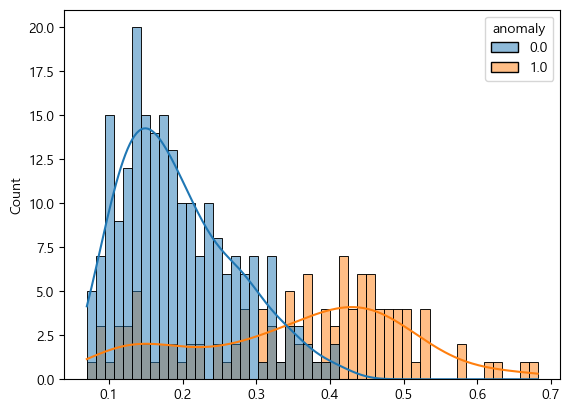

In [8]:
# 재건에러
def reconstruction_error(x, p):
    return np.mean(np.abs(x - p), axis=1)

rce = reconstruction_error(X_test, p_test)

plt.figure()
sns.histplot(x=rce, hue=y_test, bins=50, kde=True)
plt.show()

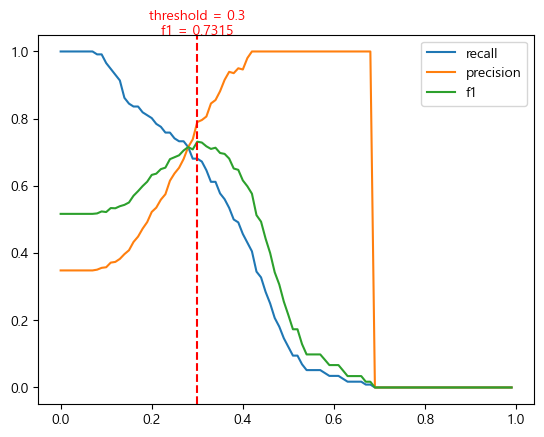

f1 score        :  0.0
recall score    :  0.0
precision score :  0.0
confusion matrix: 
 [[217   0]
 [116   0]]
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       217
         1.0       0.00      0.00      0.00       116

    accuracy                           0.65       333
   macro avg       0.33      0.50      0.39       333
weighted avg       0.42      0.65      0.51       333

11/11 [==============================] - 0s 800us/step


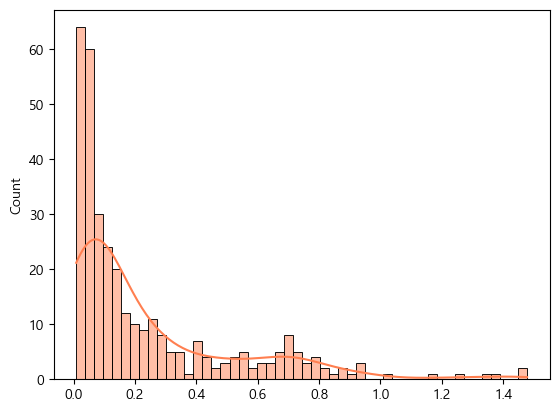

<Figure size 640x480 with 0 Axes>

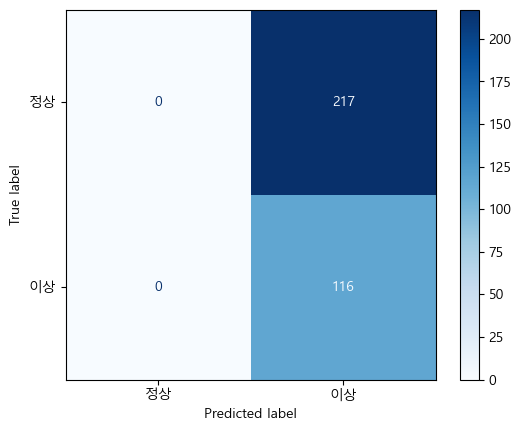

In [9]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix, precision_score, roc_curve, classification_report, ConfusionMatrixDisplay

recall = []
precision = []
f1 = []

thresholds = np.arange(0, 1, 0.01)
for thres in thresholds:
    results = rce > thres
    recall.append(recall_score(y_test, results))
    precision.append(precision_score(y_test, results))
    f1.append(f1_score(y_test, results))


plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()

print('f1 score        : ',f1_score(y_test, results))
print('recall score    : ', recall_score(y_test, results))
print('precision score : ', precision_score(y_test, results))
print('confusion matrix: \n', confusion_matrix(y_test, results))
print(classification_report(y_test, results))

# 오토인코더의 재구성 오차 계산
reconstruction_errors = np.mean(np.square(X_test - AE.predict(X_test)), axis=1)

# 이상치 여부 판단 (threshold 이상이면 이상치)
threshold = 0.0  # 임계치 설정

predicted_outliers = reconstruction_errors > threshold

# 검증 데이터의 실제 이상치 여부
actual_outliers = y_test

recall = recall_score(actual_outliers, predicted_outliers)
precision = precision_score(actual_outliers, predicted_outliers)
f1 = f1_score(actual_outliers, predicted_outliers)


plt.figure()
sns.histplot(reconstruction_errors, bins=50, kde=True, color="coral")
plt.show()

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(actual_outliers, predicted_outliers), display_labels=['정상', '이상']).plot(cmap='Blues')
plt.show()

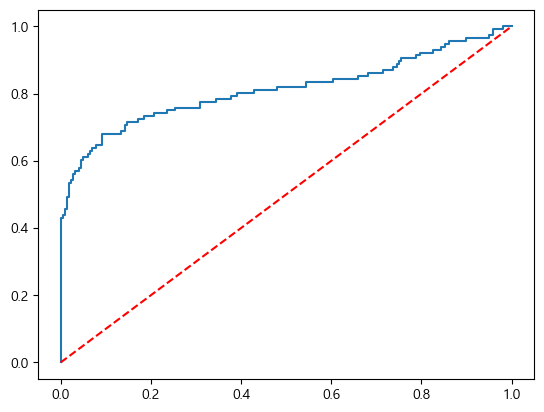

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, rce)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.show()